In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import physical_constants
import mpmath as mp

"""optical_model.py – Simple 1‑partial‑wave optical‐model toy code

Changes requested 2025‑07‑08 / 09
---------------------------------
* Keep the ENDF/B‑VI experimental data hard‑coded.
* Accept a **path** argument to read external data files with columns::

    E_lab [MeV]  delta_real [deg]  delta_imag [deg]  cross_section [mb]  S_factor [MeV*mb]

  Units are converted internally (mb → barn).
* Produce **nine** figures:
    1. Re(δ0)  – model & path data
    2. Im(δ0)  – model & path data
    3. S‑factor – model & path data
    4. σ        – model & path data
    5. σ        – experimental ENDF & path data
    6. σ        – model & experimental ENDF
    7. σ        – model, experimental ENDF & path data together
    8. u0(r)
    9. du0/dr
* Grid = True on every plot.
* Abscissa in **MeV** (except the two radial plots in fm).
* All PDFs are stored in a folder ``OpticalModelImages`` (created if absent).
"""

mp.dps = 70  # extra precision for Coulomb functions

ħc = 197.3269804                  # MeV·fm
α = 1 / 137.035999084
_e2_4pie0 = α * ħc                # MeV·fm (e^2 / 4πϵ₀)
_m_u = physical_constants['atomic mass constant energy equivalent in MeV'][0]

# ---------------------------------------------------------------------
#  ENDF/B‑VI (p, d) sample – E_lab in MeV, σ in barn
# ---------------------------------------------------------------------
_E_lab_ENDF = np.array([
      200,   300,   400,    700,    1000,   4000,   7000,  10000,  14000,
     20000, 26000, 35000,  40000,   65000,  80000,  95000, 104000, 110000,
    120000,135000,150000, 180000,  220000, 280000], dtype=float) * 1e-6  # → MeV

_sigma_ENDF = np.array([
 7.433e-39, 4.056e-31, 1.586e-26, 2.514e-19, 1.000e-15,
 1.160e-06, 1.544e-04, 1.730e-03, 1.092e-02, 5.968e-02,
 1.691e-01, 4.700e-01, 1.370e+00, 2.656e+00, 3.957e+00,
 4.801e+00, 4.980e+00, 5.010e+00, 4.877e+00, 4.465e+00,
 3.970e+00, 3.072e+00, 2.203e+00, 1.505e+00], dtype=float)  # barn

# ---------------------------------------------------------------------
#  Low‑level helpers
# ---------------------------------------------------------------------

def _reduced_mass(Ap: float, At: float) -> float:
    """Return the reduced mass μ = m_p m_t / (m_p + m_t) in MeV/c²."""
    return Ap * _m_u * At / (Ap + At)


def _coulomb_FG(l: int, eta: float, rho: float):
    """Coulomb F, G and their radial derivatives using *mpmath*."""
    F = mp.coulombf(l, eta, rho)
    G = mp.coulombg(l, eta, rho)
    Fp = mp.diff(lambda x: mp.coulombf(l, eta, x), rho)
    Gp = mp.diff(lambda x: mp.coulombg(l, eta, x), rho)
    return complex(F), complex(G), complex(Fp), complex(Gp)


def _delta0(E: float, Zp: int, Zt: int, Ap: float, At: float,
            Vr: float, Vi: float, r0: float):
    """s‑wave complex phase shift δ₀(E)."""
    μ = _reduced_mass(Ap, At)
    k = np.sqrt(2 * μ * E) / ħc
    a_c = ħc ** 2 / (μ * _e2_4pie0 * Zp * Zt)
    eta = 1.0 / (k * a_c)
    R_N = r0 * (At ** (1 / 3) + Ap ** (1 / 3))
    k_N = np.sqrt(2 * μ * (E - Vr - 1j * Vi)) / ħc
    rho = k * R_N

    F, G, Fp, Gp = _coulomb_FG(0, eta, rho)
    cot_kNR = np.cos(k_N * R_N) / np.sin(k_N * R_N)
    W = (k_N * cot_kNR * G - k * Gp) / (k * Fp - k_N * cot_kNR * F)
    delta = np.arctan(1 / W)
    return delta, W, k, a_c


def _sigma_S(E: float, k: float, W: complex, μ: float,
             Zp: int, Zt: int):
    """Return (σ, S) in barn and MeV·barn, respectively."""
    W_r, W_i = W.real, W.imag
    sigma = np.pi / k ** 2 * (-4 * W_i) / (W_r ** 2 + (W_i - 1) ** 2)  # barn
    B_G = Zp * Zt * _e2_4pie0 * np.sqrt(2 * μ) / ħc                     # MeV¹ᐟ²·fm

    # Use *mpmath* to keep exp() under control
    E_mpf = mp.mpf(E)
    try:
        S_mpf = mp.mpf(sigma) * E_mpf * mp.e ** (B_G / mp.sqrt(E_mpf))
        S = float(S_mpf) if mp.log(S_mpf) < 700 else np.nan  # cap at ~1e304
    except (OverflowError, ValueError):
        S = np.nan
    return sigma, S


def _wavefunction(r: np.ndarray, E: float, p):
    """(u, du/dr) at radius *r* for the s‑wave."""
    Zp, Zt, Ap, At, Vr, Vi, r0 = p
    μ = _reduced_mass(Ap, At)
    k = np.sqrt(2 * μ * E) / ħc
    R_N = r0 * (At ** (1 / 3) + Ap ** (1 / 3))
    delta, _, k_val, a_c = _delta0(E, *p[:4], Vr, Vi, r0)
    k_N = np.sqrt(2 * μ * (E - Vr - 1j * Vi)) / ħc

    B = 1.0  # inward‑normalised interior solution
    F0, G0, Fp0, Gp0 = _coulomb_FG(0, 1 / (k_val * a_c), k_val * R_N)
    cot_delta = 1 / np.tan(delta)
    D = B * np.sin(k_N * R_N) / (F0 * cot_delta + G0)

    u = np.where(r < R_N, B * np.sin(k_N * r), D * (F0 * cot_delta + G0))
    du = np.where(r < R_N, B * k_N * np.cos(k_N * r),
                  D * (Fp0 * cot_delta + Gp0) * k_val)
    return u, du

# ---------------------------------------------------------------------
#  User‑level driver
# ---------------------------------------------------------------------

def run_optical_model(Zp: int, Zt: int, Ap: float, At: float,
                      Vr: float, Vi: float, r0: float,
                      E_range_eV=(120.0, 168000.0), n_E=600,
                      E_demo_cm_eV: float | None = None,
                      path: str | None = None,
                      show: bool = True, save: bool = True,
                      return_data: bool = False):
    """Compute phase‑shift, σ and S‑factor curves and create nine PDFs.

    Parameters
    ----------
    Zp, Zt, Ap, At, Vr, Vi, r0 : optical‑model parameters.
    E_range_eV  : *(min, max)* CM energy (eV).
    n_E         : number of energy points (log‑spaced).
    E_demo_cm_eV: CM energy for the radial plots (eV).
    path        : external ``.dat`` file with five columns.
    show        : call ``plt.show()`` at the end of the run.
    save        : write PDFs inside *OpticalModelImages/*.
    return_data : return a dict with raw arrays.
    """
    # ░░░ preparation ░░░
    E_min, E_max = (x * 1e-6 for x in E_range_eV)          # → MeV
    E_cm = np.geomspace(E_min, E_max, n_E)                 # log spacing
    E_lab = (Ap + At) / At * E_cm                          # simple conversion

    params = (Zp, Zt, Ap, At, Vr, Vi, r0)
    μ = _reduced_mass(Ap, At)

    # ░░░ theoretical curves ░░░
    delta = []
    sigma = []
    S_factor = []
    for E in E_cm:
        dE, W, kE, _ = _delta0(E, *params)
        sigma_E, S_E = _sigma_S(E, kE, W, μ, Zp, Zt)
        delta.append(dE)
        sigma.append(sigma_E)
        S_factor.append(S_E)

    delta = np.array(delta)
    sigma = np.array(sigma)
    S_factor = np.array(S_factor)

    # ░░░ external path data ░░░
    if path and os.path.exists(path):
        dat = np.loadtxt(path, comments=['#', '%'])
        E_dat = dat[:, 0]  # MeV already
        d_re_dat = dat[:, 1]
        d_im_dat = dat[:, 2]
        sigma_dat = dat[:, 3] / 100.0         # mb → barn
        S_dat = dat[:, 4] / 100.0             # MeV·mb → MeV·barn
    else:
        E_dat = d_re_dat = d_im_dat = sigma_dat = S_dat = None

    # ░░░ output directory ░░░
    out_dir = 'OpticalModelImages'
    if save:
        os.makedirs(out_dir, exist_ok=True)

    # Helper for saving/optionally showing
    def _finalise(fig, name):
        fig.tight_layout()
        if save:
            fig.savefig(os.path.join(out_dir, name), dpi=300)
        if not show:
            plt.close(fig)

    # ------------------------------------------------------------------
    # 1. Re(δ₀)
    # ------------------------------------------------------------------
    fig1, ax1 = plt.subplots(figsize=(6, 4))
    ax1.plot(E_lab, np.degrees(delta.real), label='Model', lw=1.8)
    if E_dat is not None:
        ax1.plot(E_dat, d_re_dat, label='Path data', lw=1.5)
    ax1.set_xlabel('E_lab (MeV)')
    ax1.set_ylabel('Re δ₀ (deg)')
    ax1.grid(True)
    ax1.legend()
    _finalise(fig1, 'phase_shift_real.pdf')

    # ------------------------------------------------------------------
    # 2. Im(δ₀)
    # ------------------------------------------------------------------
    fig2, ax2 = plt.subplots(figsize=(6, 4))
    ax2.plot(E_lab, np.degrees(delta.imag), label='Model', lw=1.8)
    if E_dat is not None:
        ax2.plot(E_dat, d_im_dat, label='Path data', lw=1.5)
    ax2.set_xlabel('E_lab (MeV)')
    ax2.set_ylabel('Im δ₀ (deg)')
    ax2.grid(True)
    ax2.legend()
    _finalise(fig2, 'phase_shift_imag.pdf')

    # ------------------------------------------------------------------
    # 3. S‑factor (model & path)
    # ------------------------------------------------------------------
    fig3, ax3 = plt.subplots(figsize=(6, 4))
    ax3.plot(E_lab, S_factor, label='Model', lw=1.8)
    if E_dat is not None:
        ax3.plot(E_dat, S_dat, label='Path data', lw=1.5)
    ax3.set_xlabel('E_lab (MeV)')
    ax3.set_ylabel('S (MeV·barn)')
    ax3.set_yscale('log')
    ax3.grid(True)
    ax3.legend()
    _finalise(fig3, 'S_factor.pdf')

    # ------------------------------------------------------------------
    # 4. σ – model & path
    # ------------------------------------------------------------------
    fig4, ax4 = plt.subplots(figsize=(6, 4))
    ax4.plot(E_lab, sigma, label='Model', lw=1.8)
    if E_dat is not None:
        ax4.plot(E_dat, sigma_dat, label='Path data', lw=1.5)
    ax4.set_xlabel('E_lab (MeV)')
    ax4.set_ylabel('σ (barn)')
    ax4.set_yscale('log')
    ax4.grid(True)
    ax4.legend()
    _finalise(fig4, 'sigma_model_vs_path.pdf')

    # ------------------------------------------------------------------
    # 5. σ – experimental ENDF & path
    # ------------------------------------------------------------------
    fig5, ax5 = plt.subplots(figsize=(6, 4))
    ax5.scatter(_E_lab_ENDF, _sigma_ENDF, label='ENDF/B‑VI', lw=1.8)
    if E_dat is not None:
        ax5.plot(E_dat, sigma_dat, label='Path data', lw=1.5)
    ax5.set_xlabel('E_lab (MeV)')
    ax5.set_ylabel('σ (barn)')
    ax5.set_yscale('log')
    ax5.grid(True)
    ax5.legend()
    _finalise(fig5, 'sigma_exp_vs_path.pdf')

    # ------------------------------------------------------------------
    # 6. σ – model & experimental ENDF
    # ------------------------------------------------------------------
    fig6, ax6 = plt.subplots(figsize=(6, 4))
    ax6.plot(E_lab, sigma, label='Model', lw=1.8)
    ax6.scatter(_E_lab_ENDF, _sigma_ENDF, label='ENDF/B‑VI', lw=1.5)
    ax6.set_xlabel('E_lab (MeV)')
    ax6.set_ylabel('σ (barn)')
    ax6.set_yscale('log')
    ax6.grid(True)
    ax6.legend()
    _finalise(fig6, 'sigma_model_vs_exp.pdf')

    # ------------------------------------------------------------------
    # 7. σ – model, experimental ENDF & path (all three)
    # ------------------------------------------------------------------
    fig7, ax7 = plt.subplots(figsize=(6, 4))
    ax7.plot(E_lab, sigma, label='Model', lw=1.8)
    ax7.scatter(_E_lab_ENDF, _sigma_ENDF, label='ENDF/B‑VI', lw=1.5)
    if E_dat is not None:
        ax7.plot(E_dat, sigma_dat, label='Path data', lw=1.5)
    ax7.set_xlabel('E_lab (MeV)')
    ax7.set_ylabel('σ (barn)')
    ax7.set_yscale('log')
    ax7.grid(True)
    ax7.legend()
    _finalise(fig7, 'sigma_all_three.pdf')

    # ------------------------------------------------------------------
    # 8–9. Radial wavefunction u₀ and derivative
    # ------------------------------------------------------------------
    if E_demo_cm_eV is not None:
        E_demo = E_demo_cm_eV * 1e-6  # → MeV
        μ = _reduced_mass(Ap, At)
        a_c = ħc ** 2 / (μ * _e2_4pie0 * Zp * Zt)
        r = np.linspace(1e-4, 2 * a_c, 3000)  # fm
        u, du = _wavefunction(r, E_demo, params)

        # 8. u(r)
        fig8, ax8 = plt.subplots(figsize=(6, 4))
        ax8.plot(r, u.real, label='Re u₀')
        ax8.plot(r, u.imag, '--', label='Im u₀')
        ax8.set_xlabel('r (fm)')
        ax8.set_ylabel('u₀')
        ax8.grid(True)
        ax8.legend()
        _finalise(fig8, 'wavefunction_u0.pdf')

        # 9. du/dr
        fig9, ax9 = plt.subplots(figsize=(6, 4))
        ax9.plot(r, du.real, label='Re du₀/dr')
        ax9.plot(r, du.imag, '--', label='Im du₀/dr')
        ax9.set_xlabel('r (fm)')
        ax9.set_ylabel('du₀/dr')
        ax9.grid(True)
        ax9.legend()
        _finalise(fig9, 'wavefunction_du0.pdf')

    if show:
        plt.show()

    if return_data:
        out = {
            'E_cm_MeV': E_cm,
            'E_lab_MeV': E_lab,
            'delta': delta,
            'sigma_barn': sigma,
            'S_MeVbarn': S_factor,
            'E_lab_ENDF_MeV': _E_lab_ENDF,
            'sigma_ENDF_barn': _sigma_ENDF,
        }
        if E_dat is not None:
            out.update({
                'E_lab_path_MeV': E_dat,
                'delta_re_path_deg': d_re_dat,
                'delta_im_path_deg': d_im_dat,
                'sigma_path_barn': sigma_dat,
                'S_path_MeVbarn': S_dat,
            })
        return out

# ---------------------------------------------------------------------
#  Example of use (comment out for production)
# ---------------------------------------------------------------------
# run_optical_model(1, 2, 2, 3, Vr=10.0, Vi=5.0, r0=1.2,
#                   E_demo_cm_eV=5e4,
#                   path='../c++/OpticModel/data/datfiles_l=0_a=1/delta_vs_Elab.dat')


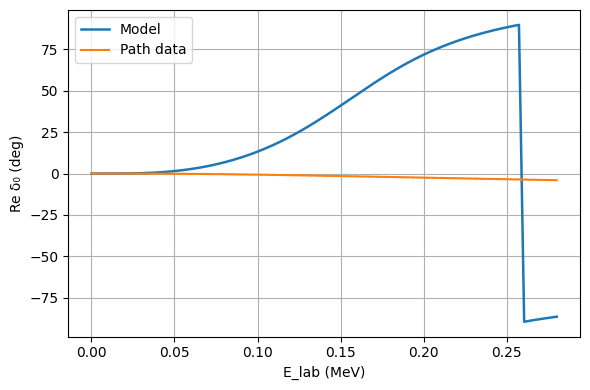

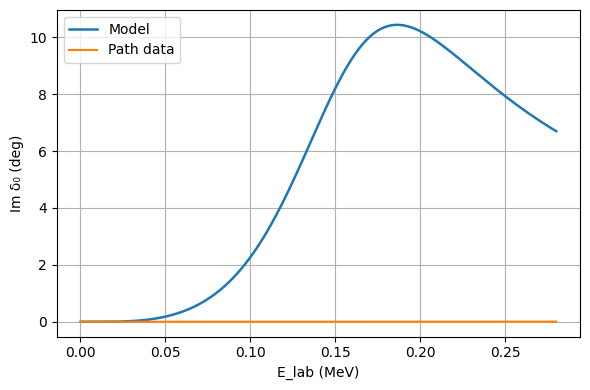

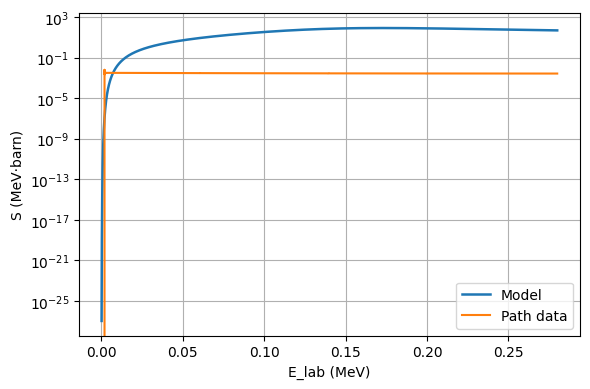

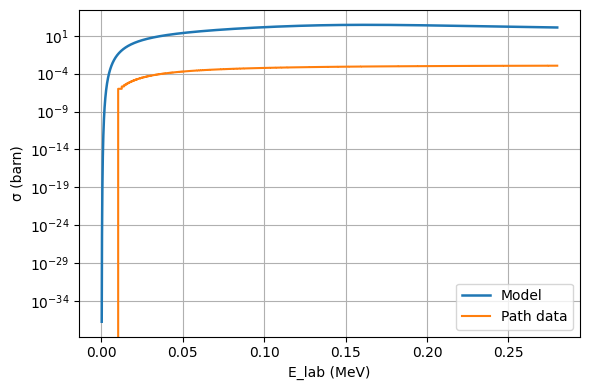

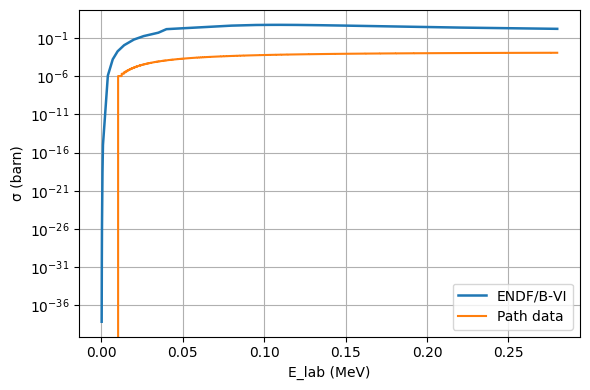

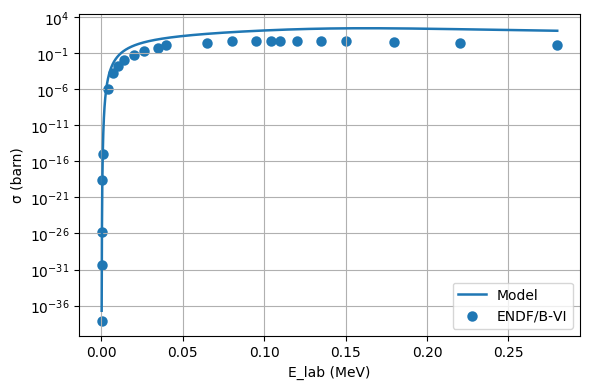

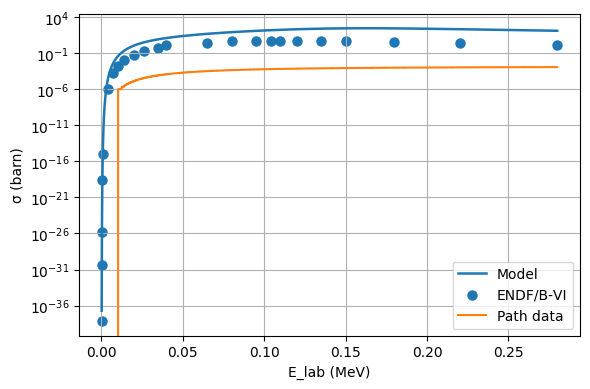

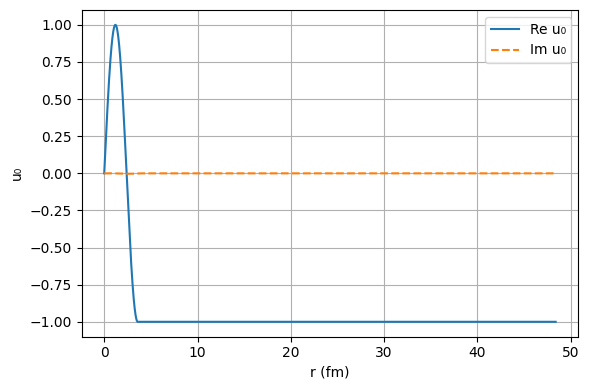

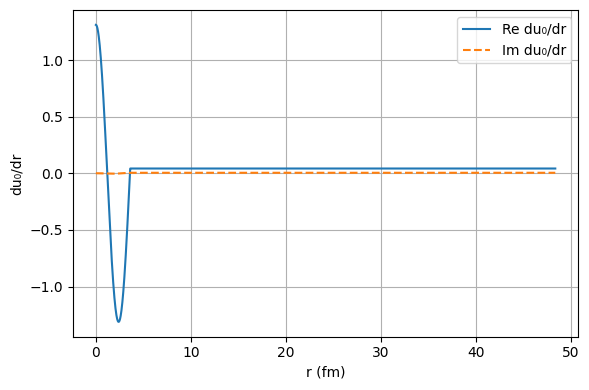

In [4]:
run_optical_model(
    Zp=1, Zt=1,        # deuterón + algo
    Ap=2, At=3,        # masas (amu)
    Vr=-30, Vi=-0.04964,   # potencial MeV
    r0=1.338,            # fm
    E_demo_cm_eV=500,     # opcional: u0(r) a 50 keV
     path='../c++/OpticModel/data/datfiles_l=0_a=3/delta_vs_Elab.dat'
)

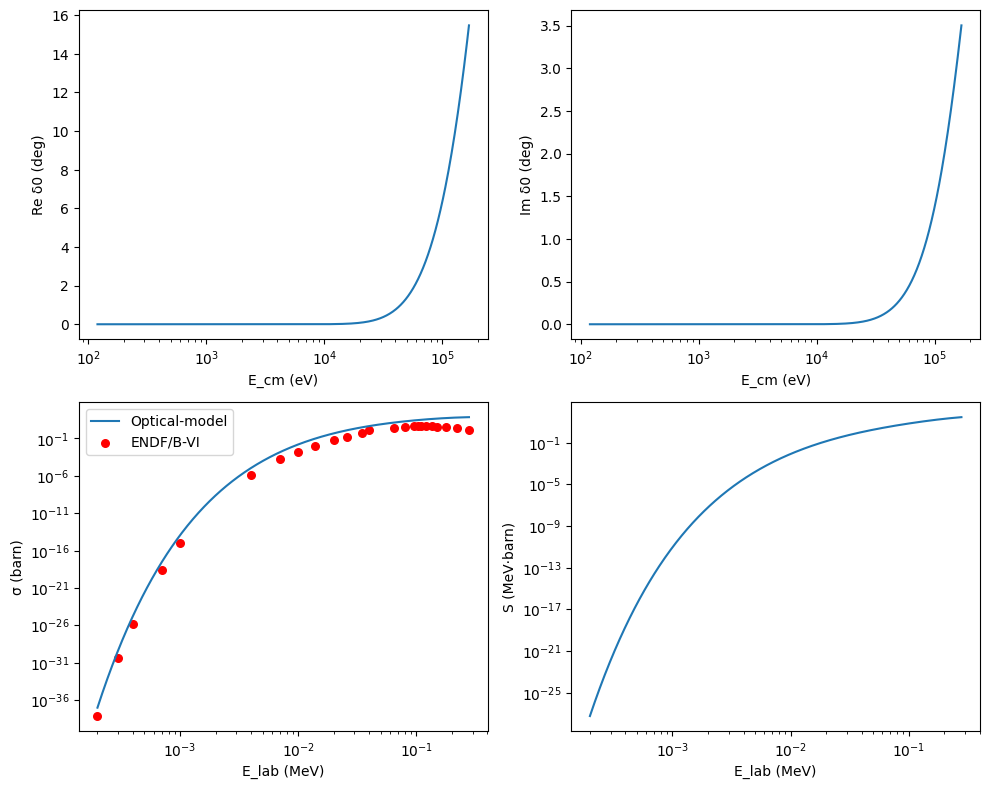

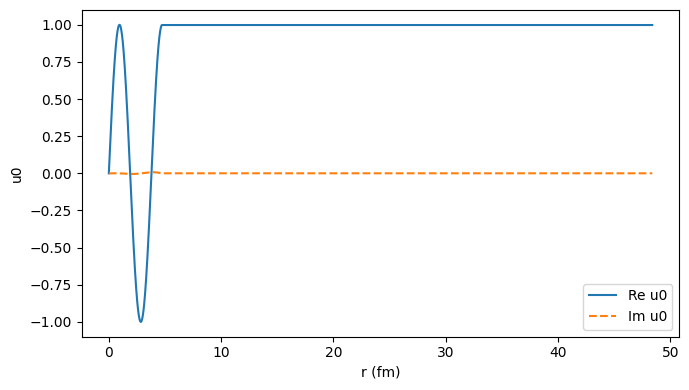

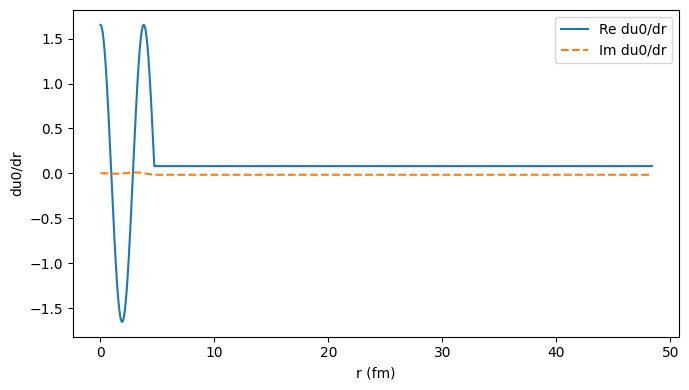

In [3]:
run_optical_model(
    Zp=1, Zt=1,        # deuterón + algo
    Ap=2, At=3,        # masas (amu)
    Vr=-47.667, Vi=-0.117292,   # potencial MeV
    r0=1.746,            # fm
    E_demo_cm_eV=500     # opcional: u0(r) a 50 keV
)

In [4]:

Ecm = (280000)/((2 + 3)/3)
print(Ecm)

168000.0


In [11]:
#media onda 
V_i = 16.8 #V_pp
V_o = 5.1 #V_pp
V_rms = V_o*2/np.pi
print(V_rms)

3.246760839074665


In [ ]:
#media onda 
V_i = 16.8 #V_pp
V_o = 5.1 #V_pp
V_rms = V_o*2/np.pi
print(V_rms)

In [12]:
#onda completa dos diodos 
V_i = 17.6 #V_pp
V_o = 8.2 #V_pp
#V_rms = V_o*2/np.pi
print(V_rms)

3.246760839074665


In [13]:
#onda completa dos diodos 
V_i = 34.4 #V_pp
V_o = 16.8 #V_pp
#V_rms = V_o*2/np.pi
print(V_rms)

3.246760839074665


In [ ]:
#onda completa 4  diodos 
V_i = 14.2 #V_pp
V_o = 8.2 #V_pp
#V_rms = V_o*2/np.pi
print(V_rms)